With an increase in online payments today,a rise in payment fraud is also increasing. The objective here was **to identify fraudulent and non-fraudulent payments**. The dataset is collected from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments.


The dataset consists of 10 variables:
* **step**: represents a unit of time where 1 step equals 1 hour
* **type**: type of online transaction
* **amount**: the amount of the transaction
* **nameOrig**: customer starting the transaction
* **oldbalanceOrg**: balance before the transaction
* **newbalanceOrig**: balance after the transaction
* **nameDest**: recipient of the transaction
* **oldbalanceDest**: initial balance of recipient before the transaction
* **newbalanceDest**: the new balance of recipient after the transaction
* **isFraud**: fraud transaction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from tabulate import tabulate
import random
import tensorflow as tf

###Exploratory Data Analysis

In [38]:
df = pd.read_csv('onlinefraud.csv')
df.drop('isFlaggedFraud', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


* The dataset consists of 6,362,620 observations after removing non-numeric columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 485.4+ MB


None

Text(0.5, 1.0, 'Correlation Matrix')

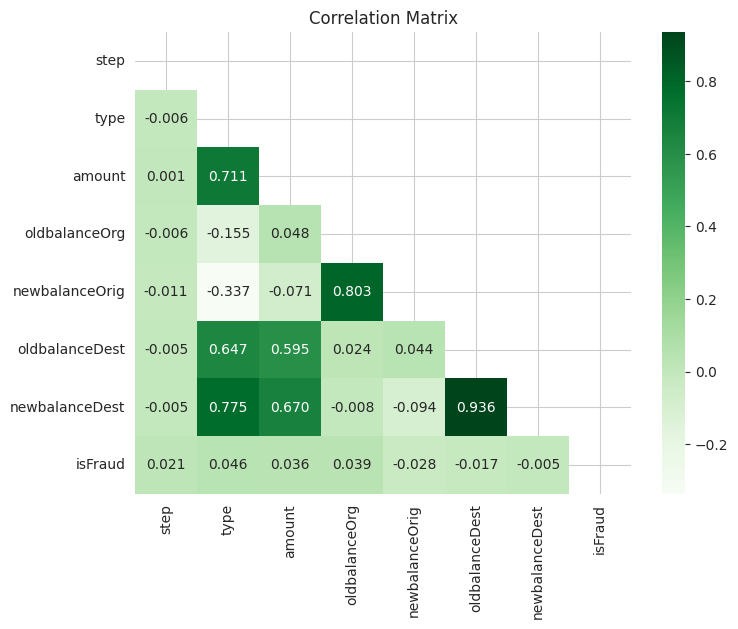

In [39]:
# Ensuring 'type' column is numerical and exclude non-numeric columns before calculating correlation
df['type'] = df['type'].map({'PAYMENT':0, 'CASH_IN':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4})

display(df.info())

# Plotting correlation matrix
corr_matrix = df.drop(['nameOrig', 'nameDest'], axis=1).corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True, mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), fmt='.3f', cmap='Greens')
plt.title('Correlation Matrix')

In [40]:
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2211419,186,3,360540.97,C1788932550,0.00,0.00,C2072026467,860870.45,1221411.42,0
3642720,275,1,144371.14,C804652731,993815.16,1138186.30,C1658488659,436830.27,292459.14,0
2417125,202,0,5184.28,C679985550,0.00,0.00,M836910188,0.00,0.00,0
3816943,281,3,59224.10,C800263018,0.00,0.00,C882437077,273865.35,333089.45,0
718677,37,3,218115.67,C324384963,6012.00,0.00,C913519726,359140.71,577256.39,0
811036,40,0,17512.84,C47022492,20093.00,2580.16,M1667885028,0.00,0.00,0
4299393,307,1,320605.68,C1739687741,6326.00,326931.68,C1008186750,0.00,0.00,0
5387044,376,3,290040.59,C8434715,9385.00,0.00,C1466234865,2196469.90,2319345.63,0
3910943,284,0,10215.71,C1593374826,82107.39,71891.68,M1072442546,0.00,0.00,0
2380613,193,0,54248.97,C877971496,610.00,0.00,M112144043,0.00,0.00,0


In [41]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


* No missing values found


In [42]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
]

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='github',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----|----------------|-------------|-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [43]:
# Downcast numerical columns with smaller dtype
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [44]:
df.duplicated().sum()

np.int64(0)

* No Duplicates found


In [45]:
df['step'].value_counts()

,count
step,
19,51352
18,49579
187,49083
235,47491
307,46968
...,...
706,4
721,4
693,4


* There are **743** steps, and every step has **at least 2** occurrences.

In [46]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

<ipython-input-47-241098435>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='type', data=df, palette='PuBu')
<ipython-input-47-241098435>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')


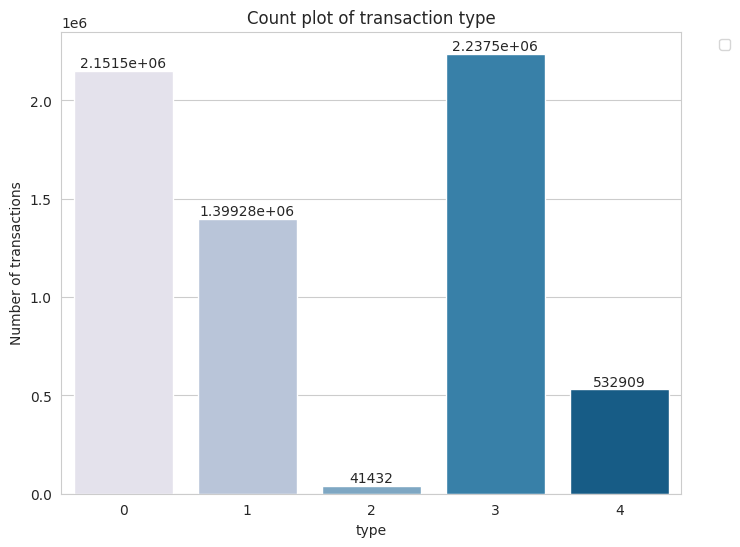

In [47]:
ax = sns.countplot(x='type', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

plt.show()

* **Cash out** is **the most numerous** transaction type.

Text(0.5, 1.0, 'Distribution of transaction amount')

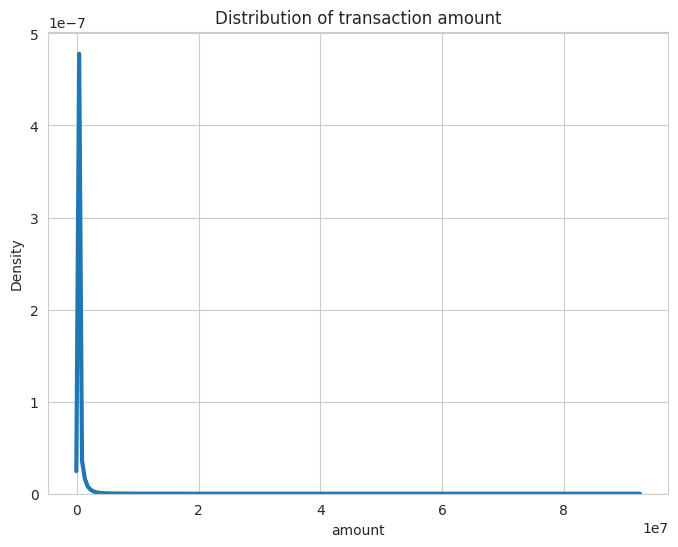

In [48]:
sns.kdeplot(df['amount'], linewidth=3)
plt.title('Distribution of transaction amount')

* The distribution of transaction amounts is **right skewed**.
* This indicates that most values are clustered around the left tail of the distribution, with the longer right tail indicating that (mode < median < mean)

In [49]:
df['nameOrig'].value_counts()

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
...,...
C1567523029,1
C644777639,1
C1256645416,1


* There are 6353307 initial customers, and every customer has at least 1 occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

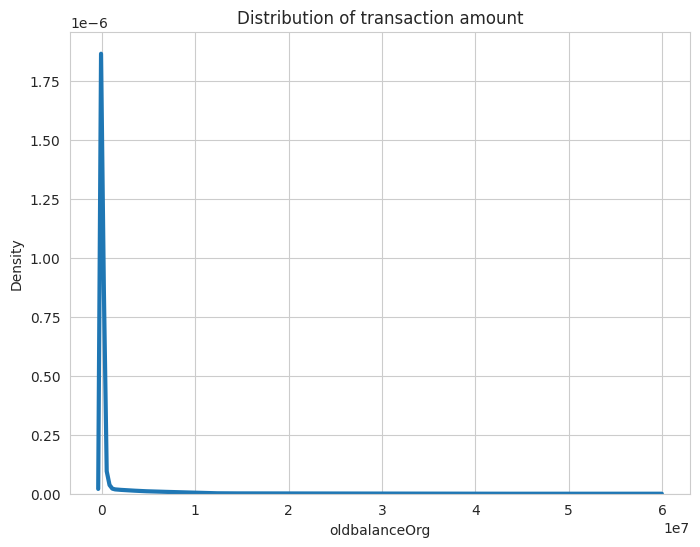

In [50]:
sns.kdeplot(df['oldbalanceOrg'], linewidth=3)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the initial customers is right skewed.

Text(0.5, 1.0, 'Distribution of transaction amount')

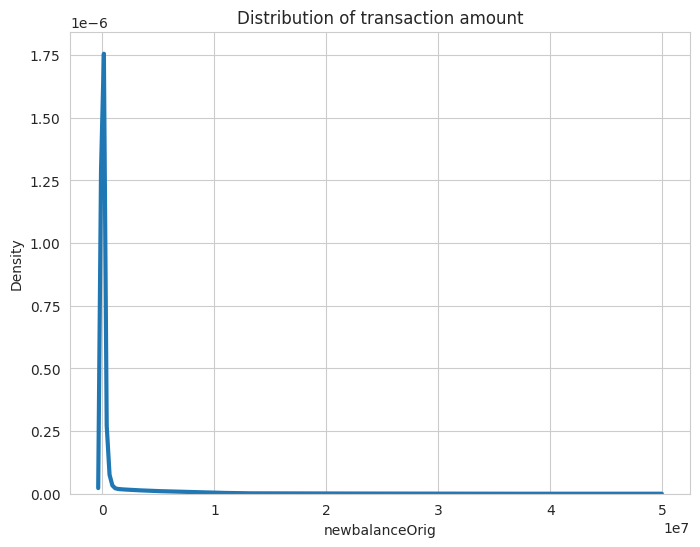

In [51]:
sns.kdeplot(df['newbalanceOrig'], linewidth=3)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the initial customers is **right skewed**.

In [52]:
df['nameDest'].value_counts()

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
...,...
M367627425,1
M1902904124,1
M242332837,1


* There are 2722362 recipients, and every recipient has at least 1
occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

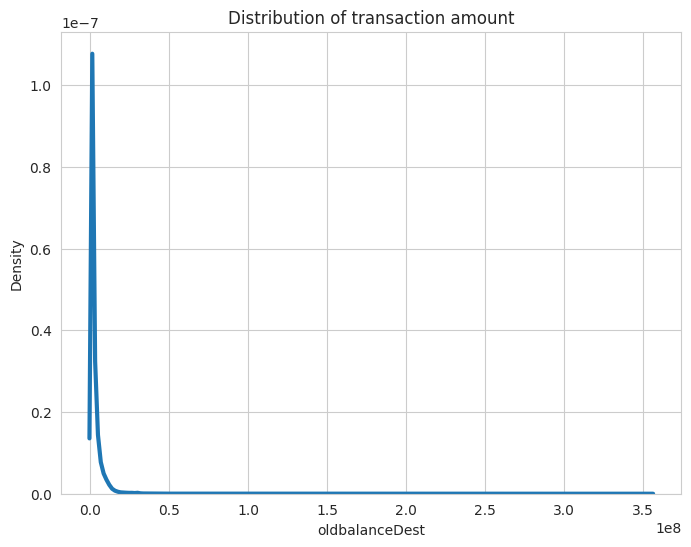

In [53]:
sns.kdeplot(df['oldbalanceDest'], linewidth=3)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the recipient is right skewed.

Text(0.5, 1.0, 'Distribution of transaction amount')

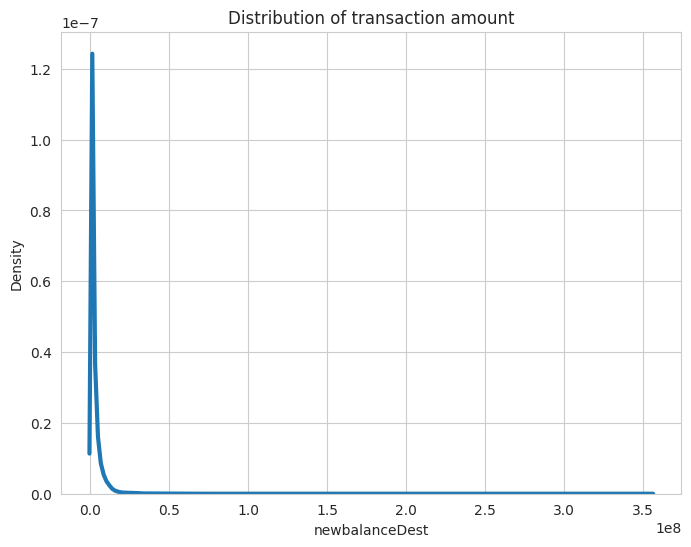

In [54]:
sns.kdeplot(df['newbalanceDest'], linewidth=3)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the recipient is right skewed.

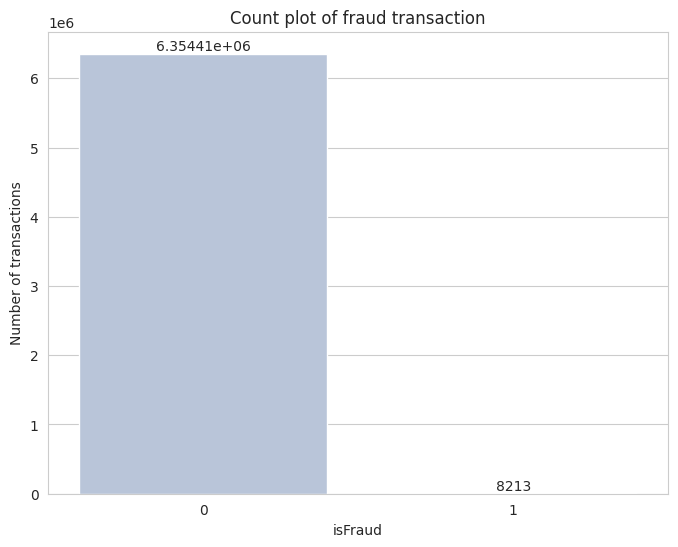

In [55]:
ax = sns.countplot(x='isFraud', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction')
plt.ylabel('Number of transactions')

del ax

plt.show()

* There are way more non-fraudulent transactions than fraudulent transactions.

###Data Visualization

<ipython-input-56-3891187721>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df.groupby(['type', 'isFraud']).size().unstack()


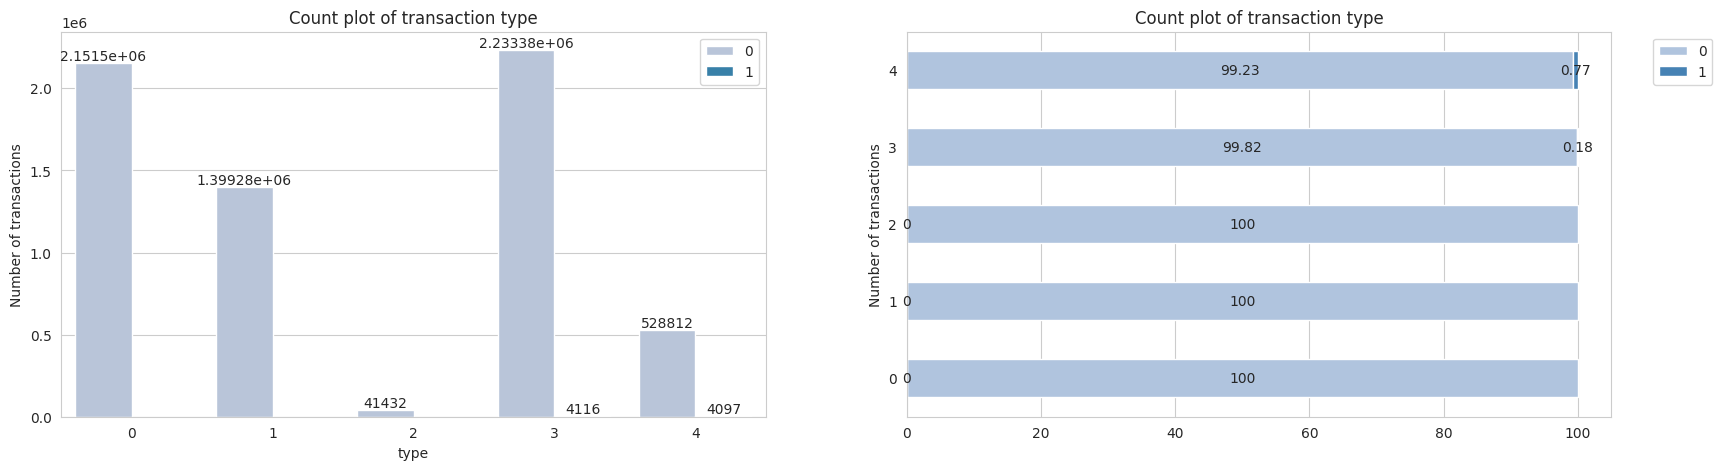

In [56]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(x='type', data=df, hue='isFraud', palette='PuBu', ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].set_title('Count plot of transaction type')
ax[0].legend(loc='best')
ax[0].set_ylabel('Number of transactions')

df2 = df.groupby(['type', 'isFraud']).size().unstack()
df2.apply(lambda x : round(x/sum(x)*100, 2), axis=1).plot(kind='barh', stacked=True, color=['lightsteelblue', 'steelblue'], ax=ax[1])
for container in ax[1].containers:
    ax[1].bar_label(container, label_type='center')
ax[1].set_title('Count plot of transaction type')
ax[1].legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax[1].set_ylabel('Number of transactions')
ax[1].grid(axis='y')

* Fraudulent transactions are occurring only in debit and transfer types.

Text(0, 0.5, 'Number of Transactions')

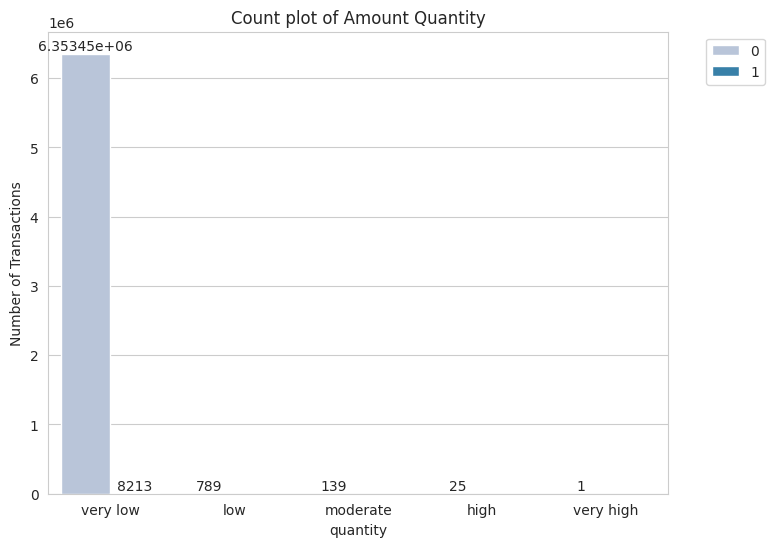

In [57]:
df['quantity'] = pd.cut(df['amount'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='quantity', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of Amount Quantity')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of Transactions')

* Most of the fraudulent transactions are falling into the category of very low amounts.

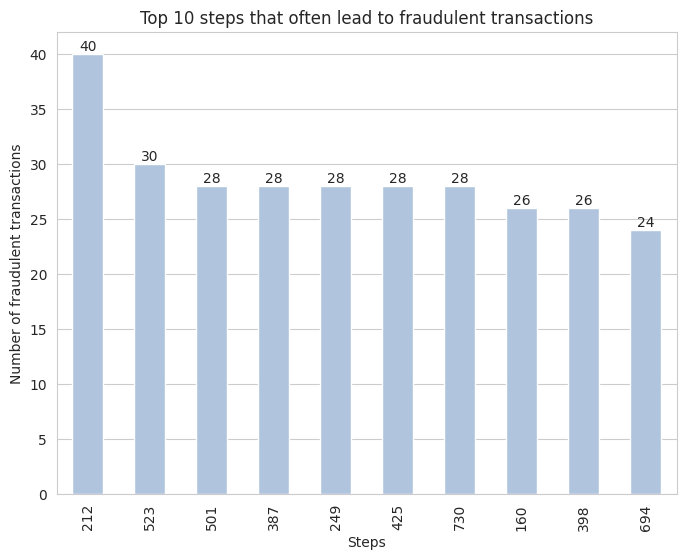

In [58]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Steps')
plt.grid(axis='x')

del ax, df2

* Step 212 has the highest number of fraudulent transactions, 40 cases.

Text(0.5, 0, 'Initial customers pre-transaction balance amount')

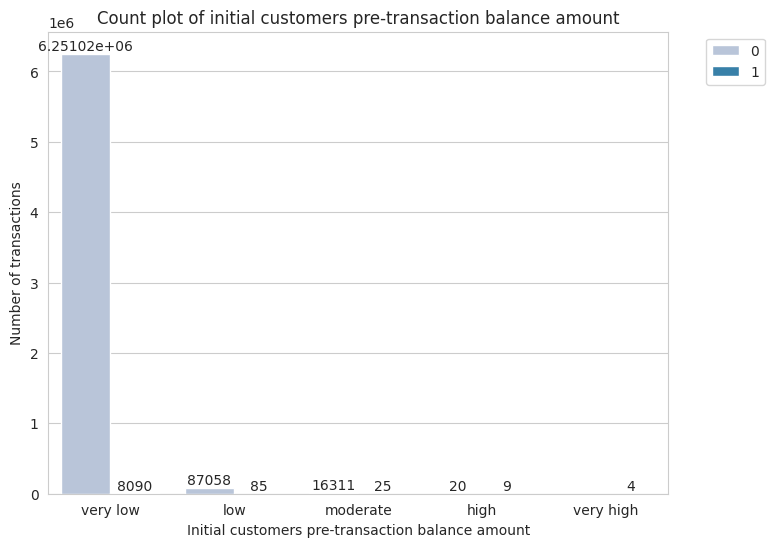

In [59]:
df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceOrg_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of initial customers pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Initial customers pre-transaction balance amount')

initial customers with very low pre-transaction balances may be more likely to fall for a fraudulent transaction.

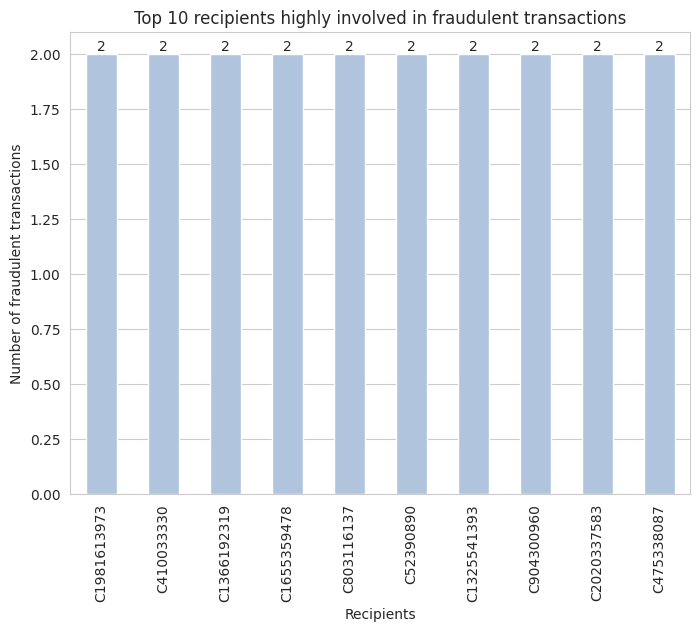

In [60]:
df2 = df1['nameDest'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 recipients highly involved in fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Recipients')
plt.grid(axis='x')

del ax, df2

* Suspicious recipients only have a maximum of 2 involved fraudulent transactions.

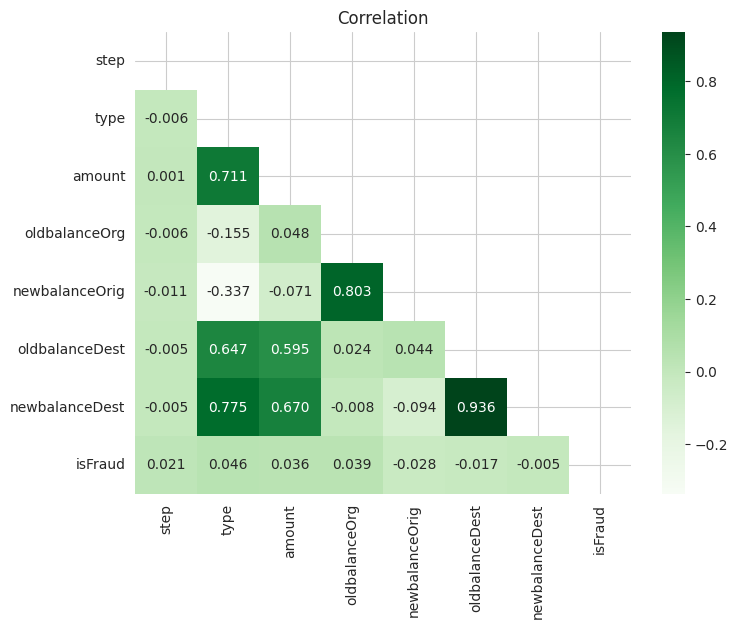

In [62]:
# Ensuring that 'type' column is numerical and excluding non-numeric columns before calculating correlation
if 'oldbalanceOrg_amt' not in df.columns:
    df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])
if 'oldbalanceDest_amt' not in df.columns:
    df['oldbalanceDest_amt'] = pd.cut(df['oldbalanceDest'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

corr_matrix = df.drop(['nameOrig', 'nameDest', 'quantity', 'oldbalanceOrg_amt', 'oldbalanceDest_amt'], axis=1).corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True, mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), fmt='.3f', cmap='Greens')
plt.title('Correlation')
plt.show()

* oldbalanceOrg and newbalanceOrig has **strong positive** relationship.
* oldbalanceDest and newbalanceDest has **strong positive** relationship.
* oldbalanceOrg and amount has **weak positive** relationship.
* newbalanceOrig and amount has **moderate positive** relationship.

Data Preprocessing

Due to the large dataset, Random Forest and Logistic Regression with balanced class weight are used to identify online payment fraud.

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import random
import tensorflow as tf

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


X = df.copy()
X.drop(['nameOrig', 'newbalanceOrig', 'nameDest', 'newbalanceDest', 'quantity', 'oldbalanceOrg_amt', 'oldbalanceDest_amt'], axis=1, inplace=True)
y = X.pop('isFraud')

nan_in_y = y.isnull()
X = X[~nan_in_y]
y = y[~nan_in_y]

# Check if 'type' column is all NaNs after removing rows with NaN in y, if all Nan, then replacing with 0 otherwise with most frequent element
if X['type'].isnull().all():
    X['type'] = X['type'].fillna(0)
else:
    imputer_type = SimpleImputer(strategy='most_frequent')
    X['type'] = imputer_type.fit_transform(X[['type']])


print("NaN count in X before scaling:", X.isnull().sum().sum())

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_idx, test_idx in skfold.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


sc = StandardScaler()
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)

X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

NaN count in X before scaling: 0


In [64]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer

def dropna_transformer(X):
    """Transformer to drop rows with NaNs from a NumPy array."""
    if isinstance(X, np.ndarray):
        return X[~np.isnan(X).any(axis=1)]
    # Fallback for DataFrame input, though pipeline should pass numpy array
    elif isinstance(X, pd.DataFrame):
        return X.dropna()
    else:
        return X


def model_comparison_evaluate(classifiers, X, y):
    print('K-Fold Cross-Validation:\n')
    for name, model in classifiers.items():
        print('{}:'.format(name))

        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        # Using a pipeline for Logistic Regression to handle imputation and explicit dropna within cross-validation
        if name == 'Logistic Regression':
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('dropna', FunctionTransformer(dropna_transformer, validate=False)),
                ('model', model)
            ])
            model_eval = pipeline
        else:
            model_eval = model

        for score in scoring:
            scores = cross_val_score(model_eval, X, y, scoring=score, cv=skfold, n_jobs=-1)
            print('Mean {} score: {:.3f} ({:.3f})'.format(score, scores.mean(), scores.std()))

        print('\n')

In [65]:
classifiers = { 'Random Forest Classifier':RandomForestClassifier(class_weight='balanced', random_state=seed),
                'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=seed, solver='liblinear')
              }

In [66]:
model_comparison_evaluate(classifiers, X_train, y_train)

K-Fold Cross-Validation:

Random Forest Classifier:
Mean accuracy score: 0.985 (0.003)
Mean precision score: 0.975 (0.006)
Mean recall score: 0.996 (0.002)
Mean f1 score: 0.985 (0.003)
Mean roc_auc score: 0.998 (0.000)


Logistic Regression:
Mean accuracy score: 0.848 (0.006)
Mean precision score: 0.843 (0.008)
Mean recall score: 0.856 (0.004)
Mean f1 score: 0.850 (0.006)
Mean roc_auc score: 0.927 (0.004)




Random Forest Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.98      1.00      0.99   1239159
    Fraud [1]       1.00      0.05      0.09     33365

     accuracy                           0.98   1272524
    macro avg       0.99      0.52      0.54   1272524
 weighted avg       0.98      0.98      0.96   1272524
 



Text(0.5, 0, 'False Positive Rate')

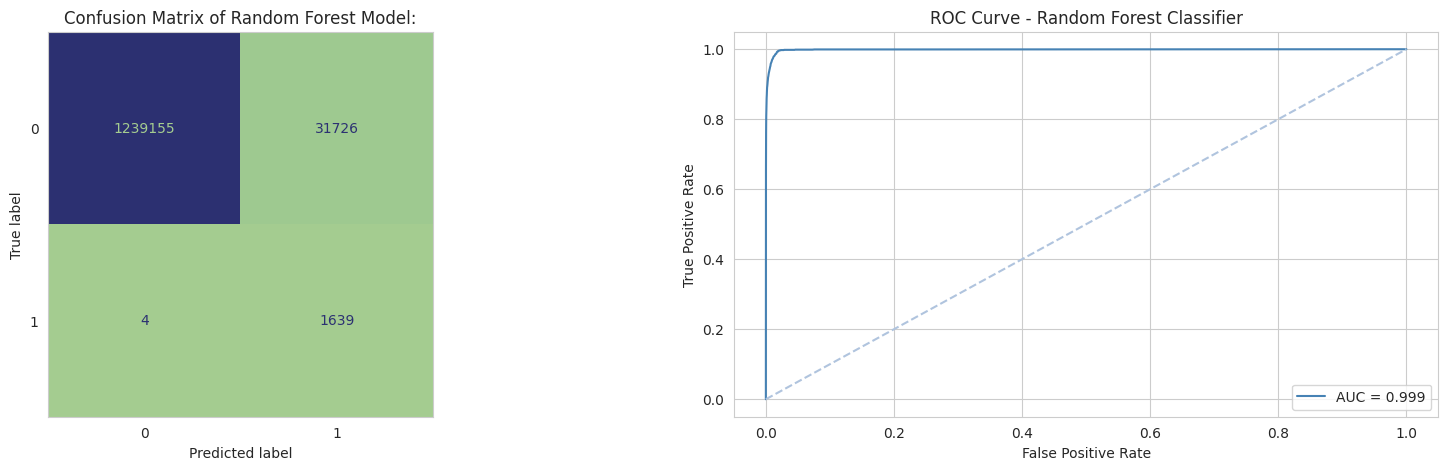

In [68]:
model = RandomForestClassifier(class_weight='balanced', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print('Random Forest Classifier:')
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of Random Forest Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Random Forest Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

* From the confusion matrix, 1,239,155 were correctly classified as non-fraudulent payments, and 31,726 people were misclassified as non-fraudulent payments.
* According to the confusion matrix, 1,639 payments were incorrectly labelled as fraud while 4 payments were correctly identified as fraud.

###Conclusion

* Random Forest obtains the highest score of all using K-fold cross-validation.
* The best performing model is **Random Forest** for identifying fraudulent and non-fraudulent payments, as the AUC is 0.999, which is close to 1. This means it has a good separability measure, and the model has an 99.9% chance of being able to distinguish between positive and negative classes.